
========== RESULTS ==========
From-Scratch MLP -> Train Accuracy: 0.71625
From-Scratch MLP -> Val Accuracy  : 0.715
From-Scratch MLP -> Training Time : 0.05 seconds

Sklearn MLP -> Train Accuracy: 0.68375
Sklearn MLP -> Val Accuracy  : 0.685
Sklearn MLP -> Training Time : 0.222 seconds



c:\Users\lohan\OneDrive\Desktop\all programs\Soft Computing\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


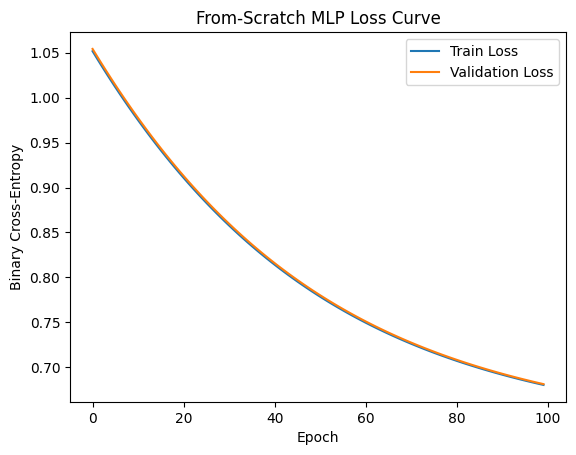

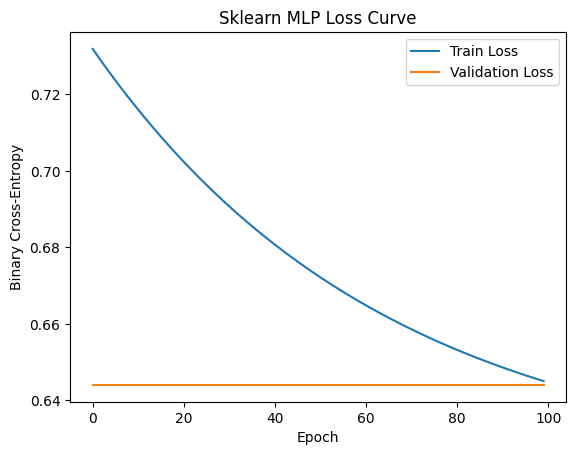

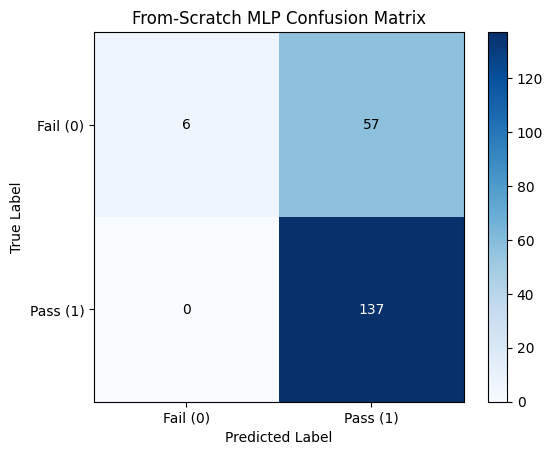

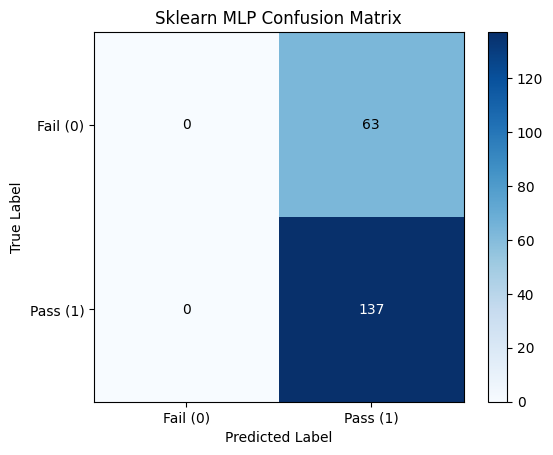

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
from sklearn.neural_network import MLPClassifier

# 1. Load Dataset
df = pd.read_csv("student_results_with_grades.csv")
X = df[["Math", "Science", "English", "History", "Computer"]].values
y = df["Final_Result"].values

# 2. Split into Train and Validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=7
)

# Standardize features so all subjects are on similar scale
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_val_std = scaler.transform(X_val)

# 3. Define MLP (From Scratch Implementation)
class MLPFromScratch:
    def __init__(self, input_dim, hidden_layers=(12,), lr=0.05, epochs=150, seed=0):
        self.input_dim = input_dim
        self.hidden_layers = list(hidden_layers)
        self.lr = lr
        self.epochs = epochs
        self.rng = np.random.default_rng(seed)
        self.weights, self.biases = [], []
        self.train_losses, self.val_losses = [], []
        self._init_params()

    def _init_params(self):
        # Initialize weights with Xavier initialization
        layer_dims = [self.input_dim] + self.hidden_layers + [1]
        for i in range(len(layer_dims)-1):
            fan_in, fan_out = layer_dims[i], layer_dims[i+1]
            limit = np.sqrt(6 / (fan_in + fan_out))
            W = self.rng.uniform(-limit, limit, size=(fan_in, fan_out))
            b = np.zeros((1, fan_out))
            self.weights.append(W)
            self.biases.append(b)

    @staticmethod
    def sigmoid(z):
        return 1.0 / (1.0 + np.exp(-z))

    @staticmethod
    def bce_loss(y_true, y_pred, eps=1e-12):
        """Binary Cross-Entropy Loss"""
        y_pred = np.clip(y_pred, eps, 1 - eps)
        return np.mean(-(y_true*np.log(y_pred) + (1-y_true)*np.log(1-y_pred)))

    def forward(self, X):
        """Forward pass through the network"""
        a = X
        activations, zs = [a], []
        for i in range(len(self.hidden_layers)):
            z = a @ self.weights[i] + self.biases[i]
            a = self.sigmoid(z)
            zs.append(z); activations.append(a)
        z = a @ self.weights[-1] + self.biases[-1]
        y_hat = self.sigmoid(z)
        zs.append(z); activations.append(y_hat)
        return activations, zs

    def fit(self, X, y, X_val=None, y_val=None):
        """Train using gradient descent"""
        y = y.reshape(-1, 1)
        if y_val is not None: y_val = y_val.reshape(-1, 1)
        n = X.shape[0]

        for epoch in range(self.epochs):
            activations, zs = self.forward(X)
            y_hat = activations[-1]

            # Save training & validation losses
            self.train_losses.append(self.bce_loss(y, y_hat))
            if X_val is not None:
                val_hat = self.predict_proba(X_val)
                self.val_losses.append(self.bce_loss(y_val, val_hat))

            # Backpropagation
            grads_W, grads_b = [None]*len(self.weights), [None]*len(self.biases)
            delta = (y_hat - y) / n
            grads_W[-1] = activations[-2].T @ delta
            grads_b[-1] = np.sum(delta, axis=0, keepdims=True)

            for l in range(len(self.hidden_layers)-1, -1, -1):
                da = delta @ self.weights[l+1].T
                a_l = activations[l+1]
                dz = da * a_l * (1 - a_l)
                grads_W[l] = activations[l].T @ dz
                grads_b[l] = np.sum(dz, axis=0, keepdims=True)
                delta = dz

            # Gradient descent update
            for i in range(len(self.weights)):
                self.weights[i] -= self.lr * grads_W[i]
                self.biases[i] -= self.lr * grads_b[i]

        return self

    def predict_proba(self, X):
        a = X
        for i in range(len(self.hidden_layers)):
            a = self.sigmoid(a @ self.weights[i] + self.biases[i])
        return self.sigmoid(a @ self.weights[-1] + self.biases[-1])

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)

# 4. Train both models (Scratch vs Sklearn)
hidden = (16, 8)   # 2 hidden layers with 16 and 8 neurons
epochs = 100
lr = 0.01

# Train From-Scratch Model
start = time.time()
mlp_scratch = MLPFromScratch(input_dim=X_train_std.shape[1], hidden_layers=hidden, lr=lr, epochs=epochs)
mlp_scratch.fit(X_train_std, y_train, X_val=X_val_std, y_val=y_val)
time_scratch = time.time() - start

# Train Sklearn Model
start = time.time()
mlp_lib = MLPClassifier(
    hidden_layer_sizes=hidden,
    activation='logistic',
    solver='sgd',
    learning_rate_init=lr,
    max_iter=epochs,
    batch_size=X_train_std.shape[0],
    momentum=0.0,
    n_iter_no_change=epochs+1,
    random_state=123
)
mlp_lib.fit(X_train_std, y_train)
time_lib = time.time() - start

# 5. Evaluate Models
print("\n========== RESULTS ==========")
print("From-Scratch MLP -> Train Accuracy:", accuracy_score(y_train, mlp_scratch.predict(X_train_std)))
print("From-Scratch MLP -> Val Accuracy  :", accuracy_score(y_val, mlp_scratch.predict(X_val_std)))
print("From-Scratch MLP -> Training Time :", round(time_scratch, 3), "seconds\n")

print("Sklearn MLP -> Train Accuracy:", accuracy_score(y_train, mlp_lib.predict(X_train_std)))
print("Sklearn MLP -> Val Accuracy  :", accuracy_score(y_val, mlp_lib.predict(X_val_std)))
print("Sklearn MLP -> Training Time :", round(time_lib, 3), "seconds")
print("=============================\n")

# 6. Plot Loss Curves
plt.plot(mlp_scratch.train_losses, label="Train Loss")
plt.plot(mlp_scratch.val_losses, label="Validation Loss")
plt.title("From-Scratch MLP Loss Curve")
plt.xlabel("Epoch"); plt.ylabel("Binary Cross-Entropy")
plt.legend(); plt.show()

plt.plot(mlp_lib.loss_curve_, label="Train Loss")
val_loss_lib = log_loss(y_val, mlp_lib.predict_proba(X_val_std)[:, 1])
plt.plot([val_loss_lib]*len(mlp_lib.loss_curve_), label="Validation Loss")
plt.title("Sklearn MLP Loss Curve")
plt.xlabel("Epoch"); plt.ylabel("Binary Cross-Entropy")
plt.legend(); plt.show()

# 7. Confusion Matrices
def plot_cm(cm, title):
    plt.imshow(cm, cmap="Blues", interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["Fail (0)", "Pass (1)"])
    plt.yticks(tick_marks, ["Fail (0)", "Pass (1)"])
    thresh = cm.max() / 2
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

plot_cm(confusion_matrix(y_val, mlp_scratch.predict(X_val_std)), "From-Scratch MLP Confusion Matrix")
plot_cm(confusion_matrix(y_val, mlp_lib.predict(X_val_std)), "Sklearn MLP Confusion Matrix")
